In [1]:
phase_colors = {"FCC_A1": "red", "BCC_A2": "blue", "HCP_A3": "purple"}
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v


Text(0, 0.5, 'V')

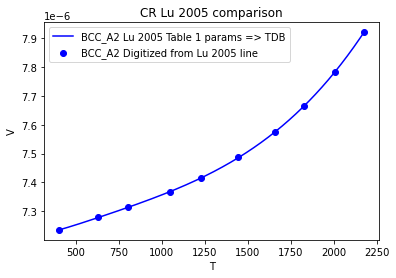

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v

element = "CR"
phase = "BCC_A2"
# Cr, Figure 8c
t_exp, v_exp = zip(*[
(405.82726326742977, 0.000007235796045785639),
(629.5525494276794, 0.000007279084287200831),
(806.4516129032259, 0.00000731404786680541),
(1045.7856399583766, 0.000007365660770031217),
(1230.4890738813733, 0.0000074156087408949),
(1446.4099895941727, 0.00000748720083246618),
(1659.729448491155, 0.000007576274713839749),
(1826.222684703434, 0.000007663683662851196),
(2005.7232049947966, 0.000007781893860561913),
(2174.817898022892, 0.000007920083246618106),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} Lu 2005 comparison")
#plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label=f"{phase} Lu 2005 Table 1 params => TDB", c=phase_colors[phase])
plt.scatter(t_exp, v_exp, label=f"{phase} Digitized from Lu 2005 line", c=phase_colors[phase])
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

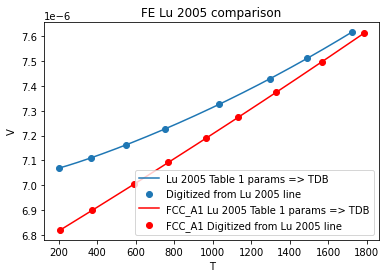

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v

element = "FE"
phase = "BCC_A2"
# Fe, Figure 10b
t_exp, v_exp = zip(*[
(204.5765183549271, 0.000007070345489443379),
(368.6281972228369, 0.000007110940499040307),
(551.769439499093, 0.000007162763915547025),
(754.0057343709115, 0.000007228406909788868),
(1032.5728369400335, 0.000007326007677543187),
(1299.7132814544143, 0.000007429654510556622),
(1490.5430452912829, 0.00000751084452975048),
(1721.4621730960293, 0.0000076162188099808065),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label="Lu 2005 Table 1 params => TDB")
plt.scatter(t_exp, v_exp, label="Digitized from Lu 2005 line")
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

element = "FE"
phase = "FCC_A1"
# Fe, Figure 10b
t_exp, v_exp = zip(*[
(209.7692894613093, 0.0000068215930902111325),
(371.9912392572029, 0.000006898464491362764),
(593.3811380548877, 0.000007005566218809981),
(768.9692587218605, 0.000007091938579654511),
(963.6451130681074, 0.000007188675623800384),
(1131.6050932338444, 0.000007274184261036468),
(1330.1032516115333, 0.000007375239923224568),
(1566.77687734777, 0.000007497024952015355),
(1784.3700883210217, 0.00000761190019193858),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} Lu 2005 comparison")
#plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label=f"{phase} Lu 2005 Table 1 params => TDB", c=phase_colors[phase])
plt.scatter(t_exp, v_exp, label=f"{phase} Digitized from Lu 2005 line", c=phase_colors[phase])
plt.legend()


Text(0, 0.5, 'V')

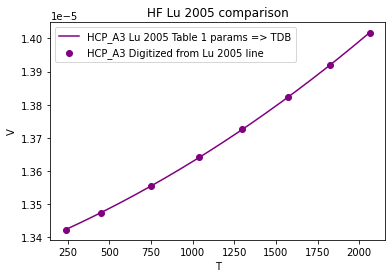

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v

element = "HF"
phase = "HCP_A3"
# Hf, Figure 12
t_exp, v_exp = zip(*[
(238.56858846918487, 0.00001342191235059761),
(452.286282306163, 0.000013473705179282868),
(750.497017892644, 0.000013555378486055778),
(1038.7673956262424, 0.00001364203187250996),
(1297.2166998011928, 0.000013726693227091633),
(1575.5467196819088, 0.000013824302788844621),
(1824.0556660039763, 0.000013918924302788844),
(2065.109343936382, 0.000014016533864541832),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} Lu 2005 comparison")
#plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label=f"{phase} Lu 2005 Table 1 params => TDB", c=phase_colors[phase])
plt.scatter(t_exp, v_exp, label=f"{phase} Digitized from Lu 2005 line", c=phase_colors[phase])
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

Text(0, 0.5, 'V')

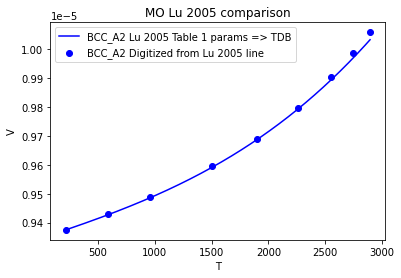

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v

### NOT Fixed
element = "MO"
phase = "BCC_A2"
# Mo, Figure 15
t_exp, v_exp = zip(*[
(214.5015105740182, 0.000009375151515151516),
(586.1027190332328, 0.000009429292929292929),
(960.7250755287008, 0.000009488282828282829),
(1504.5317220543807, 0.000009594949494949496),
(1897.2809667673714, 0.000009687878787878788),
(2259.818731117825, 0.000009796161616161615),
(2552.8700906344416, 0.000009903636363636363),
(2743.2024169184297, 0.000009986060606060605),
(2894.2598187311187, 0.000010058787878787877),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} Lu 2005 comparison")
#plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label=f"{phase} Lu 2005 Table 1 params => TDB", c=phase_colors[phase])
plt.scatter(t_exp, v_exp, label=f"{phase} Digitized from Lu 2005 line", c=phase_colors[phase])
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

Text(0, 0.5, 'V')

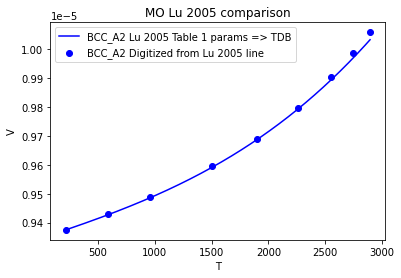

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v

### Fixed
element = "MO"
phase = "BCC_A2"
# Mo, Figure 15
t_exp, v_exp = zip(*[
(214.5015105740182, 0.000009375151515151516),
(586.1027190332328, 0.000009429292929292929),
(960.7250755287008, 0.000009488282828282829),
(1504.5317220543807, 0.000009594949494949496),
(1897.2809667673714, 0.000009687878787878788),
(2259.818731117825, 0.000009796161616161615),
(2552.8700906344416, 0.000009903636363636363),
(2743.2024169184297, 0.000009986060606060605),
(2894.2598187311187, 0.000010058787878787877),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} Lu 2005 comparison")
#plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label=f"{phase} Lu 2005 Table 1 params => TDB", c=phase_colors[phase])
plt.scatter(t_exp, v_exp, label=f"{phase} Digitized from Lu 2005 line", c=phase_colors[phase])
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

Text(0, 0.5, 'V')

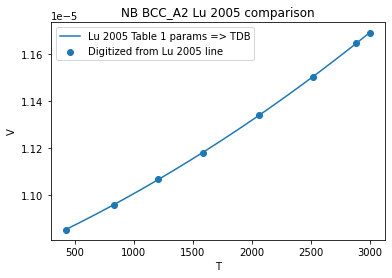

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v

element = "NB"
phase = "BCC_A2"
# Nb, Figure 16
# Note: The y-axis is mislabeled in the paper! The scale should actually be 1e-5 instead of 1e-6
t_exp, v_exp = zip(*[
(423.35025380710647, 0.0000108540733197556),
(828.4263959390865, 0.000010961303462321792),
(1206.0913705583757, 0.000011067617107942972),
(1583.7563451776655, 0.000011181262729124235),
(2058.883248730965, 0.000011338900203665986),
(2515.736040609138, 0.00001150295315682281),
(2881.218274111676, 0.000011645010183299389),
(3000.000000000001, 0.000011689002036659877),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label="Lu 2005 Table 1 params => TDB")
plt.scatter(t_exp, v_exp, label="Digitized from Lu 2005 line")
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

Text(0, 0.5, 'V')

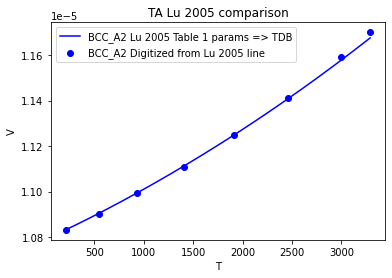

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v

element = "TA"
phase = "BCC_A2"
# Ta, Figure 25
t_exp, v_exp = zip(*[
(210.93750000000045, 0.000010831589467005076),
(542.4107142857149, 0.000010903333031182017),
(930.8035714285718, 0.000010992109318346627),
(1406.2500000000005, 0.000011108870558375634),
(1915.178571428572, 0.000011248765409717186),
(2457.5892857142862, 0.00001141301214648296),
(2993.3035714285716, 0.000011590662617839013),
(3291.2946428571427, 0.000011700186276287165),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} Lu 2005 comparison")
#plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label=f"{phase} Lu 2005 Table 1 params => TDB", c=phase_colors[phase])
plt.scatter(t_exp, v_exp, label=f"{phase} Digitized from Lu 2005 line", c=phase_colors[phase])
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

Text(0, 0.5, 'V')

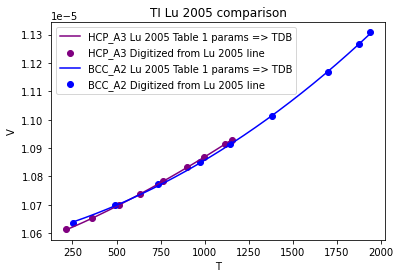

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v

element = "TI"
phase = "HCP_A3"
# Ti, Figure 26
t_exp, v_exp = zip(*[
(211.9540229885057, 0.000010613534593921609),
(362.7586206896552, 0.000010654428233175483),
(513.5632183908044, 0.00001070039924186843),
(631.2643678160917, 0.000010737921974699305),
(765.5172413793101, 0.000010783561495364505),
(901.6091954022986, 0.000010831908168256299),
(999.0804597701148, 0.000010868762478045312),
(1118.6206896551723, 0.000010914069732541855),
(1154.4827586206898, 0.000010928609684519443),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} Lu 2005 comparison")
#plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label=f"{phase} Lu 2005 Table 1 params => TDB", c=phase_colors[phase])
plt.scatter(t_exp, v_exp, label=f"{phase} Digitized from Lu 2005 line", c=phase_colors[phase])
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

element = "TI"
phase = "BCC_A2"
# Ti, Figure 26
t_exp, v_exp = zip(*[
(254.7263681592038, 0.000010635200000000001),
(493.53233830845744, 0.0000106992),
(736.3184079601986, 0.000010772800000000001),
(975.1243781094522, 0.0000108512),
(1142.2885572139298, 0.0000109128),
(1381.0945273631833, 0.000011012),
(1703.482587064676, 0.0000111696),
(1874.6268656716406, 0.0000112672),
(1940.2985074626854, 0.000011307999999999999),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} Lu 2005 comparison")
#plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label=f"{phase} Lu 2005 Table 1 params => TDB", c=phase_colors[phase])
plt.scatter(t_exp, v_exp, label=f"{phase} Digitized from Lu 2005 line", c=phase_colors[phase])
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

Text(0, 0.5, 'V')

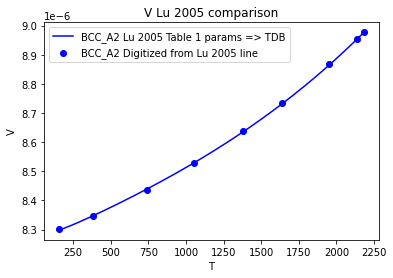

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v

element = "V"
phase = "BCC_A2"
# V, Figure 27
t_exp, v_exp = zip(*[
(158.38206627680358, 0.000008300686274509804),
(380.1169590643277, 0.000008346666666666668),
(738.3040935672517, 0.000008437254901960785),
(1055.0682261208576, 0.000008529901960784314),
(1381.5789473684213, 0.000008639019607843137),
(1639.8635477582848, 0.000008735784313725491),
(1951.7543859649127, 0.00000886686274509804),
(2136.9395711500974, 0.000008954705882352942),
(2180.7992202729047, 0.000008977352941176472),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} Lu 2005 comparison")
#plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label=f"{phase} Lu 2005 Table 1 params => TDB", c=phase_colors[phase])
plt.scatter(t_exp, v_exp, label=f"{phase} Digitized from Lu 2005 line", c=phase_colors[phase])
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

Text(0, 0.5, 'V')

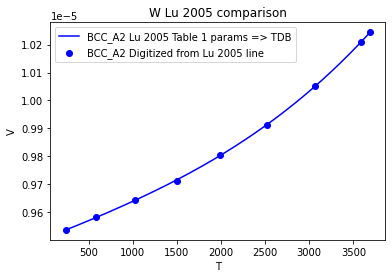

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v

element = "W"
phase = "BCC_A2"
# W, Figure 28
t_exp, v_exp = zip(*[
(241.3087934560316, 0.000009537782340862422),
(588.9570552147239, 0.000009582135523613964),
(1030.6748466257668, 0.000009642915811088296),
(1496.932515337423, 0.000009713552361396304),
(1991.8200408997945, 0.000009804722792607804),
(2519.427402862985, 0.000009912320328542094),
(3063.3946830265845, 0.000010050308008213553),
(3591.0020449897743, 0.00001020965092402464),
(3689.161554192228, 0.000010244147843942504),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} Lu 2005 comparison")
#plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label=f"{phase} Lu 2005 Table 1 params => TDB", c=phase_colors[phase])
plt.scatter(t_exp, v_exp, label=f"{phase} Digitized from Lu 2005 line", c=phase_colors[phase])
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

Text(0, 0.5, 'V')

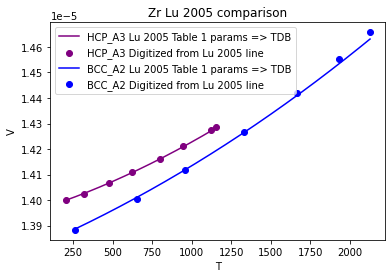

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v

element = "Zr"
phase = "HCP_A3"
# Zr, Figure 30
t_exp, v_exp = zip(*[
(203.63636363636368, 0.000013998516643490354),
(319.0909090909091, 0.000014025571603945768),
(479.09090909090907, 0.000014067330686163742),
(622.7272727272726, 0.0000141084273965757),
(799.0909090909089, 0.00001416222552363984),
(946.3636363636361, 0.000014211016697809839),
(1122.7272727272725, 0.000014273849241699984),
(1154.5454545454545, 0.000014285547214496785),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} Lu 2005 comparison")
#plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label=f"{phase} Lu 2005 Table 1 params => TDB", c=phase_colors[phase])
plt.scatter(t_exp, v_exp, label=f"{phase} Digitized from Lu 2005 line", c=phase_colors[phase])
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

element = "Zr"
phase = "BCC_A2"
# Zr, Figure 30
t_exp, v_exp = zip(*[
(261.2704918032788, 0.000013883236566484517),
(655.7377049180327, 0.000014006238615664844),
(957.9918032786886, 0.000014116311854887674),
(1326.8442622950818, 0.000014266175242865816),
(1664.9590163934422, 0.000014419753718882817),
(1931.352459016393, 0.00001455298838797814),
(2126.0245901639337, 0.000014657545916818457),
])

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, [element], phase)
vol_expr = mod.molar_volume.subs({v.Y(phase, 0, v.Species(element)): 1.0})
f = lambdify([v.T], [vol_expr], )
t_plot = np.linspace(t_exp[0], t_exp[-1], 1001)
plt.title(f"{element} Lu 2005 comparison")
#plt.title(f"{element} {phase} Lu 2005 comparison")
plt.plot(t_plot, f(t_plot), label=f"{phase} Lu 2005 Table 1 params => TDB", c=phase_colors[phase])
plt.scatter(t_exp, v_exp, label=f"{phase} Digitized from Lu 2005 line", c=phase_colors[phase])
plt.legend()
plt.xlabel("T")
plt.ylabel("V")

```json
{
    "components": ["TA", "W"],
    "phases": ["BCC_A2"],
    "conditions": {"P": 101315, "T": 298.15},
    "excluded_model_contributions": ["idmix", "mag"],
    "output": "V0",
    "solver": {
        "mode": "manual",
        "sublattice_site_ratios": [1],
        "sublattice_configurations": [[["MO", "NB"]], [["MO", "NB"]], [["MO", "NB"]]],
        "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]
    },
    "values": [[[9.526215601863577e-06, 9.813023467194888e-06, 1.014875728175819e-05]]],
    "reference": "VASP (LLNL)",
    "bibtex": "UNPUBLISHED",
    "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
    "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
}
```

## Ta-W
```json
{
    "components": ["TA", "W"],
    "phases": ["BCC_A2"],
    "conditions": {"P": 101315, "T": 298.15},
    "excluded_model_contributions": ["idmix", "mag"],
    "output": "V0",
    "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]], [["TA", "W"]], [["TA", "W"]]], "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]},
    "values": [[[1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06]]],
    "reference": "VASP (LLNL)",
    "bibtex": "UNPUBLISHED",
    "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
    "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
}
```

In [13]:
from pycalphad import Database
dbf = Database("lu2005-volumes.tdb")

from tinydb import where

dft_v0 = {  # extracted from my datasets manually
    "CR": 6.739268466639369e-06,
    "FE": 6.51563576361165e-06,
    "MO": 9.250831259667694e-06 ,
    "NB": 1.054294147118097e-05,
    "TA": 1.0647630286378038e-05,
    "TI": 9.955397913193213e-06,
    "V":  7.80944386109345e-06,
    "W":  9.46802634958327e-06,
    "ZR": 1.3139079428031535e-05,
}

print("Database")
print("--------")
V0_param_query = (
    (where('phase_name') == "BCC_A2") & \
    (where('parameter_type') == 'V0') & \
    (where('constituent_array').test(lambda subls: len(subls[0]) == 1))
)
print("Phase name  |  Component   |  TDB-DFT ")
# print("Phase name  |  Component  |  TDB  |  DFT  |  TDB-DFT ")
for param in dbf._parameters.search(V0_param_query):
    el = param['constituent_array'][0][0].name
    val = float(param['parameter'].args[0])
    # print(f"{param['phase_name']} {el:<2} {val:0.5g} {dft_v0[el]:0.5g} {val - dft_v0[el]:0.3g} %diff {(val - dft_v0[el])*100/val:0.3g}")
    print(f"{param['phase_name']} {el:<2} {(val - dft_v0[el])*100/val:0.3g}%")


Database
--------
Phase name  |  Component   |  TDB-DFT 
BCC_A2 CR 4.28%
BCC_A2 FE 7.02%
BCC_A2 MO 1.02%
BCC_A2 NB 1.94%
BCC_A2 TA 1.29%
BCC_A2 TI 6.01%
BCC_A2 V  5.32%
BCC_A2 W  0.371%
BCC_A2 ZR 4.87%


In [14]:
v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}


## Plot the _MIX data shifted to Calphad refstate

[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

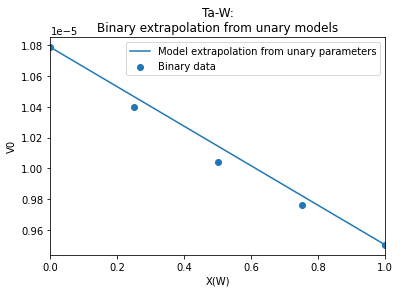

In [15]:

dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, ["TA", "W"], "BCC_A2")

x_TA = np.linspace(0, 1, 1001)
x_W = 1-x_TA
x_TA_W = np.empty((x_TA.shape[-1], 2))
x_TA_W[:, 0] = x_TA
x_TA_W[:, 1] = x_W
func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Ta-W:\nBinary extrapolation from unary models")
plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model extrapolation from unary parameters")
plt.scatter(data_5pt_x_W, data_5pt_V0_fix, label='Binary data')
plt.legend()
plt.xlabel("X(W)")
plt.ylabel("V0")
plt.xlim(0, 1)

## Plot _MIX data and real data discrepancy

[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

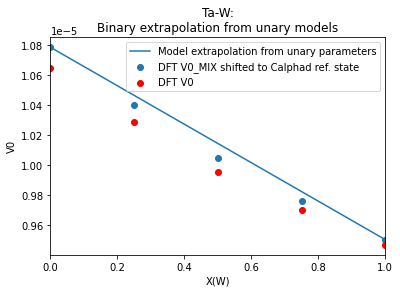

In [16]:
dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, ["TA", "W"], "BCC_A2")

x_TA = np.linspace(0, 1, 1001)
x_W = 1-x_TA
x_TA_W = np.empty((x_TA.shape[-1], 2))
x_TA_W[:, 0] = x_TA
x_TA_W[:, 1] = x_W
func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Ta-W:\nBinary extrapolation from unary models")
plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model extrapolation from unary parameters")
plt.scatter(data_5pt_x_W, data_5pt_V0_fix, label='DFT V0_MIX shifted to Calphad ref. state')
plt.scatter(data_5pt_x_W, data_5pt_V0, label='DFT V0', c='r')
plt.legend(loc='upper right')
plt.xlabel("X(W)")
plt.ylabel("V0")
plt.xlim(0, 1)

# Start here!

In [17]:
from typing import Any, List, Optional
from dataclasses import dataclass
import itertools
from numpy.typing import ArrayLike
import numpy as np
import symengine
from pycalphad import Model
from espei.paramselect import _build_feature_matrix
from espei.parameter_selection.model_building import make_successive, build_redlich_kister_candidate_models
from espei.paramselect import *
import matplotlib.pyplot as plt
import numpy as np
from symengine import lambdify
from pycalphad import Database, Model, variables as v


Dataset = Dict[str, Any]  # Typing stub

class FittingStep():
    parameter_name: str
    data_types_read: List[str]
    features: List[symengine.Expr]
    supported_reference_states: List[str]

    @staticmethod
    def transform_data(d: ArrayLike, model: Optional[Model] = None) -> ArrayLike:  # data may be muddied with symbols from Model
        return d

    @staticmethod
    def transform_feature(f: symengine.Expr, model: Optional[Model] = None) -> symengine.Expr:
        return f

    @classmethod
    def get_feature_sets(cls):
        return make_successive(cls.features)


class ModelFittingDescription():
    def __init__(self, *fitting_steps) -> None:
        self.fitting_steps = fitting_steps


class StepV0(FittingStep):
    parameter_name = "V0"
    data_types_read = ["V0"]
    features = [symengine.S.One]
    supported_reference_states = [""]  # TODO: add mixing support

class StepLogVA(FittingStep):
    # V = V0*exp(VA), to linearize in terms of VA features, we want to fit
    # VA = ln(V/V0)
    parameter_name = "VA"
    data_types_read = ["VM"]
    features = [v.T, v.T**2, v.T**3, v.T**(-1)]
    supported_reference_states = [""]  # TODO: add mixing support

    @staticmethod
    def transform_data(d, model: Model) -> ArrayLike:
        # We are given samples of volume (V) as our data (d).
        # ln(V/V0) = VA
        # cast to object_ because the real type may become a symengine.Expr
        d = np.asarray(d, dtype=np.object_)
        for i in range(d.shape[0]):
            d[i] = symengine.log(d[i] / model.V0)
        return d

    @classmethod
    def get_feature_sets(cls):
        # All combinations of features
        return list(itertools.chain(*(itertools.combinations(cls.features, n) for n in range(1, len(cls.features)+1))))


In [18]:
from espei.parameter_selection.selection import fit_model, select_model

In [93]:
from espei.core_utils import filter_configurations, filter_temperatures

# Modified version of the following import
# from espei.parameter_selection.utils import _get_sample_condition_dicts
# the idea of the modified version is that we also compute the actual site fractions
# individual site fractions are not currently handled by ESPEI, but can slip in
# from existing models if not using a reference state where those contributions
# cancel (e.g. no _MIX or _FORM refstates keep the unary extrapolation).
# to do this, we'll use the config tuple and create site fractions from the points dict
from espei.parameter_selection.redlich_kister import calc_interaction_product
def _get_sample_condition_dicts(calculate_dict, configuration_tuple, phase_name) -> List[Dict[Symbol, float]]:
    sublattice_dof = list(map(len, configuration_tuple))
    sample_condition_dicts = []
    for sample_idx in range(calculate_dict["values"].size):
        cond_dict = {}
        points = calculate_dict["points"][sample_idx, :]

        # T and P
        cond_dict[v.T] = calculate_dict["T"][sample_idx]
        cond_dict[v.P] = calculate_dict["P"][sample_idx]

        # YS site fraction product
        site_fraction_product = np.prod(points)
        cond_dict[Symbol("YS")] = site_fraction_product

        # Reconstruct site fractions in sublattice form from points
        # Required so we can identify which sublattices have interactions
        points_idxs = [0] + np.cumsum(sublattice_dof).tolist()
        site_fractions = []
        for subl_idx in range(len(points_idxs)-1):
            subl_site_fractions = points[points_idxs[subl_idx]:points_idxs[subl_idx+1]]
            for species_name, site_frac in zip(configuration_tuple[subl_idx], subl_site_fractions):
                cond_dict[v.Y(phase_name, subl_idx, species_name)] = site_frac
            site_fractions.append(subl_site_fractions.tolist())

        # Z (binary) or V_I, V_J, V_K (ternary) interaction products
        interaction_product = calc_interaction_product(site_fractions)
        if hasattr(interaction_product, "__len__"):
            # Ternary interaction
            assert len(interaction_product) == 3
            cond_dict[Symbol("V_I")] = interaction_product[0]
            cond_dict[Symbol("V_J")] = interaction_product[1]
            cond_dict[Symbol("V_K")] = interaction_product[2]
        else:
            cond_dict[Symbol("Z")] = interaction_product

        sample_condition_dicts.append(cond_dict)
    return sample_condition_dicts

# modification of espei.parameter_selection.utils.get_data_quantities
# this modified version changes how we access the property of the fixed model to subtract out that contribution
from espei.parameter_selection.utils import build_sitefractions, feature_transforms, shift_reference_state
def get_data_quantities(desired_property, fixed_model, fixed_portions, data, sample_condition_dicts):
    """
    Parameters
    ----------
    desired_property : str
        String property corresponding to the features that could be fit, e.g. HM, SM_FORM, CPM_MIX
    fixed_model : pycalphad.Model
        Model with all lower order (in composition) terms already fit. Pure
        element reference state (GHSER functions) should be set to zero.
    fixed_portions : List[symengine.Basic]
        SymEngine expressions for model parameters and interaction productions for
        higher order (in T) terms for this property, e.g. [0, 3.0*YS*v.T]. In
        [qty]/mole-formula.
    data : List[Dict[str, Any]]
        ESPEI single phase datasets for this property.

    Returns
    -------
    np.ndarray[:]
        Ravelled data quantities in [qty]/mole-formula

    Notes
    -----
    pycalphad Model parameters (and therefore fixed_portions) are stored as per
    mole-formula quantites, but the calculated properties and our data are all
    in [qty]/mole-atoms. We multiply by mole-atoms/mole-formula to convert the
    units to [qty]/mole-formula.

    """
    mole_atoms_per_mole_formula_unit = fixed_model._site_ratio_normalization
    # Define site fraction symbols that will be reused
    YS = Symbol('YS')
    Z = Symbol('Z')
    V_I, V_J, V_K = Symbol('V_I'), Symbol('V_J'), Symbol('V_K')
    phase_name = fixed_model.phase_name

    # Construct flattened list of site fractions corresponding to the ravelled data (from shift_reference_state)
    site_fractions = []
    for ds in data:
        for _ in ds['conditions']['T']:
            sf = build_sitefractions(phase_name, ds['solver']['sublattice_configurations'], ds['solver'].get('sublattice_occupancies', np.ones((len(ds['solver']['sublattice_configurations']), len(ds['solver']['sublattice_configurations'][0])), dtype=np.float_)))
            site_fractions.append(sf)
    site_fractions = list(itertools.chain(*site_fractions))

    if desired_property in feature_transforms:
        feat_transform = feature_transforms[desired_property]
    elif desired_property.startswith("V0"):
        feat_transform = lambda x: x  # TODO: hack because V0 should be V0 subtracted out
    else:
        feat_transform = lambda x: 0  # TODO: hack because VA shouldn't subtract out V0 contributions from model
    # print("data_qtys 1", data)
    data_qtys = np.concatenate(shift_reference_state(data, feat_transform, fixed_model, mole_atoms_per_mole_formula_unit), axis=-1)
    # print("data_qtys 2", data_qtys)
    # Remove existing partial model contributions from the data, convert to per mole-formula units
    # TODO: assumption of Gibbs energy fitting here - assumes that we're always fitting against the existing ast/GM.
    data_qtys = data_qtys - feat_transform(getattr(fixed_model, desired_property))*mole_atoms_per_mole_formula_unit
    # print("data_qtys 3", data_qtys)
    # Subtract out high-order (in T) parameters we've already fit, already in per mole-formula units
    data_qtys = data_qtys - feat_transform(sum(fixed_portions))
    # print("data_qtys 4", data_qtys)
    # if any site fractions show up in our data_qtys that aren't in this datasets site fractions, set them to zero.
    for sf, i, cond_dict in zip(site_fractions, data_qtys, sample_condition_dicts):
        missing_variables = symengine.S(i).atoms(v.SiteFraction) - set(sf.keys())
        # print("missing vars", missing_variables)
        sf.update({x: 0. for x in missing_variables})
        # The equations we have just have the site fractions as YS
        # and interaction products as Z, so take the product of all
        # the site fractions that we see in our data qtys
        sf.update(cond_dict)
    # print("data_qtys 5", data_qtys)
    data_qtys = [symengine.S(i).xreplace(sf).evalf() for i, sf in zip(data_qtys, site_fractions)]
    # print("data_qtys 6", data_qtys)
    data_qtys = np.asarray(data_qtys, dtype=np.float_)
    # print("data_qtys 7", data_qtys)
    return data_qtys

def fit_model_x(model_fitting_description: ModelFittingDescription, datasets, dbf):
    for fitting_step in model_fitting_description.fitting_steps:
        # TODO: hardcoded
        comps = datasets[0]["components"]
        phase = datasets[0]["phases"][0]
        fixed_model = Model(dbf, comps, phase)
        print("fitting_step", fitting_step)
        desired_data = [ds for ds in datasets if any(ds["output"].startswith(dtype) for dtype in fitting_step.data_types_read)] # TODO: proper query datasets for matches
        # configuration = [["TA", "W"]]  # maybe needs to be canonical? not sure
        configuration = datasets[0]["solver"]["sublattice_configurations"][0]  # maybe needs to be canonical? not sure
        symmetry = None
        desired_data = filter_configurations(desired_data, configuration, symmetry)
        # print("filter_configurations", desired_data)
        desired_data = filter_temperatures(desired_data)
        # print("filter_temperatures", desired_data)
        if len(desired_data) == 0:
            print("exiting with no data")
            # early exit, nothing to do with our data
            return  # TODO: match expected return type

        config_tup = tuple(map(tuplify, configuration))
        calculate_dict = get_prop_samples(desired_data, config_tup)
        # print("calculate_dict", calculate_dict)
        sample_condition_dicts = _get_sample_condition_dicts(calculate_dict, config_tup, fixed_model.phase_name)
        # print("sample_condition_dicts", sample_condition_dicts)
        # We assume all properties in the same fitting step have the same
        # features (all CPM, all HM, etc., but different ref states).
        # data quantities are the same for each candidate model and can be computed up front
        # TODO: support that we can possibly have multiple data types per feature type
        fixed_portions = []  # TODO: we need to support the fact that there's fixed_portions from earlier fitting steps. e.g. VA has a V0 fixed portion
        # print("desired_data", desired_data)
        data_qtys = get_data_quantities(fitting_step.data_types_read[0], fixed_model, fixed_portions, desired_data, sample_condition_dicts)
        # print("data_qtys", data_qtys)

        candidate_models = []
        # Transform param-only features to parameter+RK features
        feature_sets = build_redlich_kister_candidate_models(config_tup, fitting_step.get_feature_sets())
        for features in feature_sets:
            feature_matrix = _build_feature_matrix(sample_condition_dicts, list(map(fitting_step.transform_feature, features)))
            # print("feature_matrix", feature_matrix)
            data_quantities = fitting_step.transform_data(data_qtys, fixed_model)
            # one last sweep through subs sample_condition_dicts because our transform from the fixed model may have re-introduced symbols
            # print("data_quantities", data_quantities)
            # unforunately we need to handle the case that data quanities didn't get made into a symbolic form
            data_quantities = np.asarray([(dq.subs(scd) if not isinstance(dq, float) else dq) for dq, scd in zip(data_quantities, sample_condition_dicts)], dtype=np.object_)
            # print("data_quantities x", data_quantities)
            candidate_model = (features, feature_matrix, data_quantities)
            print("features", features)
            # print("candidate_model", candidate_model)
            # TODO: maybe need to substitite our sample condition dicts manually somewhere if the site fractions didn't get subbed properly. TBD
            candidate_models.append(candidate_model)
            # coeffs = fit_model(feature_matrix, data_quantities, 1e-100)
            # print(features)
        # print('candidate_models', candidate_models)
        selected_features, selected_coeffs = select_model(candidate_models, 1e-100, 1.0)
        print("selected_features", selected_features, selected_coeffs)
        # TODO: hardcoded, don't do this :)
        # We do this to solve for the problem where VA parameters depend on V0 model contributions being in the database (i.e., so VA doesn't divide by the model V0 = 0 (div by zero))
        if fitting_step.parameter_name == "V0":
            # TODO: dbf defined in outer scope. beware!!
            # TODO: Doesn't account for higher order excess parameters
            print(f"Adding V0 parameters to {fixed_model.phase_name} {tuple(map(tuplify, configuration))} {selected_coeffs[0]}")
            dbf.add_parameter(fitting_step.parameter_name, fixed_model.phase_name, tuple(map(tuplify, configuration)), 0, selected_coeffs[0])


## Unary fitting

Using Hf here so we can use the same TDB (there's no BCC data for Hf)

The data itself is fictious and based on Lu 2005 Al data.

In [94]:
molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
datasets = [
    # Hf
    {
        "components": ["HF"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["HF"]]], "sublattice_occupancies": [[[1.0]]]},
        "values": [[[10.1092e-6]]],
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    },
    {
        "components": ["HF"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": [274.5886654478977, 317.001828153565, 376.9652650822671, 455.94149908592334, 531.9926873857406, 602.1937842778796, 691.4076782449727, 850.8226691042048, 945.8866544789764, 1081.9012797074956, 1232.5411334552105]},
        "output": "VM",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["HF"]]], "sublattice_occupancies": [[[1.0]]]},
        "values": [[[0.0000102595070150209], [0.000010282702483979838], [0.000010316942197393508], [0.00001036333044520191], [0.000010413028200193464], [0.000010467137734726063], [0.00001052456686435235], [0.000010640519998161758], [0.000010715609696499606], [0.000010824930365395328], [0.000010955226490404716]]],
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]

# print(f"Model components (for verification): {mod.components}")

In [95]:
dbf = Database("lu2005-volumes.tdb")
mod_nofit = Model(dbf, ["HF"], "BCC_A2")
fit_model_x(molar_volume_fit_desc, datasets, dbf)


fitting_step <class '__main__.StepV0'>
features [1]
selected_features [1] [1.01092e-05]
Adding V0 parameters to BCC_A2 (('HF',),) 1.01092e-05
fitting_step <class '__main__.StepLogVA'>
features [T]
features [T**2]
features [T**3]
features [T**(-1)]
features [T, T**2]
features [T, T**3]
features [T, T**(-1)]
features [T**2, T**3]
features [T**2, T**(-1)]
features [T**3, T**(-1)]
features [T, T**2, T**3]
features [T, T**2, T**(-1)]
features [T, T**3, T**(-1)]
features [T**2, T**3, T**(-1)]
features [T, T**2, T**3, T**(-1)]
selected_features [T, T**2] [4.93114124e-05 1.28961475e-08]


In [22]:
# add the new parameters manually
dbf.add_parameter("VA", "BCC_A2", [["HF"]], 0, 4.93114124e-05*v.T + 1.28961475e-08*v.T**2)
mod = Model(dbf, ["HF"], "BCC_A2")


Pre-fit plot

Text(0, 0.5, 'VM')

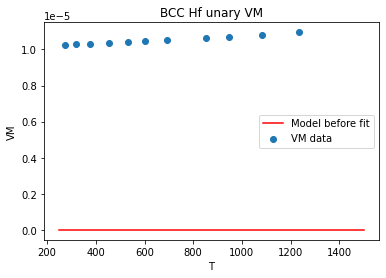

In [23]:
pT = np.linspace(250, 1500, 1001)
func_HF_VM_nofit = lambdify([v.T], [mod_nofit.VM.subs({v.Y("BCC_A2", 0, "HF"): 1.0})])
func_HF_VM = lambdify([v.T], [mod.VM.subs({v.Y("BCC_A2", 0, "HF"): 1.0})])

# raw V0s from DFT
data_T = np.asarray(datasets[1]["conditions"]["T"])
data_VM = np.asarray(datasets[1]["values"]).squeeze()


plt.title("BCC Hf unary VM")
# plt.plot(pT, func_HF_VM(pT), label="Model after fit")
plt.plot(pT, func_HF_VM_nofit(pT), label="Model before fit", c='r')
plt.scatter(data_T, data_VM, label='VM data')
plt.legend()
plt.xlabel("T")
plt.ylabel("VM")
# plt.xlim(0, 1)

Text(0, 0.5, 'VM')

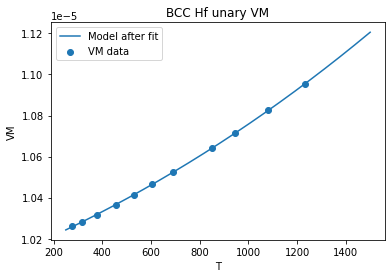

In [24]:
pT = np.linspace(250, 1500, 1001)
func_HF_VM_nofit = lambdify([v.T], [mod_nofit.VM.subs({v.Y("BCC_A2", 0, "HF"): 1.0})])
func_HF_VM = lambdify([v.T], [mod.VM.subs({v.Y("BCC_A2", 0, "HF"): 1.0})])

# raw V0s from DFT
data_T = np.asarray(datasets[1]["conditions"]["T"])
data_VM = np.asarray(datasets[1]["values"]).squeeze()


plt.title("BCC Hf unary VM")
plt.plot(pT, func_HF_VM(pT), label="Model after fit")
# plt.plot(pT, func_HF_VM_nofit(pT), label="Model before fit", c='r')
plt.scatter(data_T, data_VM, label='VM data')
plt.legend()
plt.xlabel("T")
plt.ylabel("VM")
# plt.xlim(0, 1)

## Binary fitting

### Basic 1 point data

In [25]:
molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
datasets = [
    # dummy dataset for 50/50 composition, eventually these should be real ESPEI datasets
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "output": "V0",
        "values": [[[1.00448925e-05]]],  # "fixed" value (absolute value from mix data with calphd reference state) extracted manually from above
        "conditions": {"T": 298.15, "P": 101325},
        "solver": {"sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]]], "sublattice_occupancies": [[[0.5, 0.5]]]},
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, ["TA", "W"], "BCC_A2")

print(f"Model components (for verification): {mod.components}")

Model components (for verification): [Species('TA', 'TA1'), Species('W', 'W1')]


In [26]:
fit_model_x(molar_volume_fit_desc, datasets, dbf)  # parameter added automatically

fitting_step <class '__main__.StepV0'>
sample_condition_dicts [{T: 298.15, P: 101325.0, YS: 0.25, Y(BCC_A2,0,TA): 0.5, Y(BCC_A2,0,W): 0.5, Z: 0.0}]
data_qtys 1 [{'components': ['TA', 'W'], 'phases': ['BCC_A2'], 'output': 'V0', 'values': [[[1.00448925e-05]]], 'conditions': {'T': array([298.15]), 'P': 101325}, 'solver': {'sublattice_site_ratios': [1], 'sublattice_configurations': ((('TA', 'W'),),), 'sublattice_occupancies': [[[0.5, 0.5]]]}, 'reference': 'VASP (LLNL)', 'bibtex': 'UNPUBLISHED', 'comment': 'Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING', 'tags': ['non-equilibrium-thermochemical', 'LLNL-proprietary']}]
data_qtys 2 [1.00448925e-05*(BCC_A20TA + BCC_A20W)]
data_qtys 3 [-1.0*(1.07866e-05*BCC_A20TA + 9.50328e-06*BCC_A20W)*(BCC_A20TA + BCC_A20W) + 1.00448925e-05*(BCC_A20TA + BCC_A20W)]
data_qtys 4 [-1.0*(1.07866e-05*BCC_A20TA + 9.50328e-06*BCC_A20W)*(BCC_A20TA + BCC_A20W) + 1.00448925e-05*(BCC_A20TA + BCC_A20W)]
data_qtys [-1.000475e-07]
candidat

[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

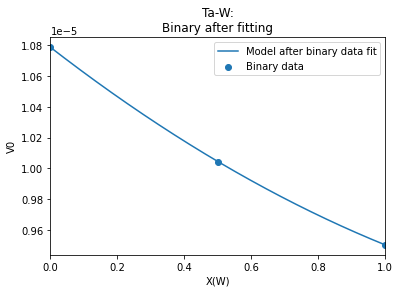

In [27]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "W"], "BCC_A2")

x_TA = np.linspace(0, 1, 1001)
x_W = 1-x_TA
x_TA_W = np.empty((x_TA.shape[-1], 2))
x_TA_W[:, 0] = x_TA
x_TA_W[:, 1] = x_W
func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

data_1pt_x_W = data_5pt_x_W[[0,2,4]]
data_1pt_V0 = data_5pt_V0_fix[[0,2,4]]

plt.title("Ta-W:\nBinary after fitting")
plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model after binary data fit")
plt.scatter(data_1pt_x_W, data_1pt_V0, label='Binary data')
plt.legend()
plt.xlabel("X(W)")
plt.ylabel("V0")
plt.xlim(0, 1)

Repeat the above, but now use a real dataset

In [28]:
molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
datasets = [
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]], [["TA", "W"]], [["TA", "W"]]], "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]},
        "values": [[[1.04002492e-05, 1.00448925e-05, 9.76045653e-06]]],  # fixed values from calculation w/ calphad refstate
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
dbf = Database("lu2005-volumes.tdb")
mod = Model(dbf, ["TA", "W"], "BCC_A2")

print(f"Model components (for verification): {mod.components}")

Model components (for verification): [Species('TA', 'TA1'), Species('W', 'W1')]


In [29]:
fit_model_x(molar_volume_fit_desc, datasets, dbf)

fitting_step <class '__main__.StepV0'>
sample_condition_dicts [{T: 298.15, P: 101315.0, YS: 0.1875, Y(BCC_A2,0,TA): 0.75, Y(BCC_A2,0,W): 0.25, Z: 0.5}, {T: 298.15, P: 101315.0, YS: 0.25, Y(BCC_A2,0,TA): 0.5, Y(BCC_A2,0,W): 0.5, Z: 0.0}, {T: 298.15, P: 101315.0, YS: 0.1875, Y(BCC_A2,0,TA): 0.25, Y(BCC_A2,0,W): 0.75, Z: -0.5}]
data_qtys 1 [{'components': ['TA', 'W'], 'phases': ['BCC_A2'], 'conditions': {'P': 101315, 'T': array([298.15])}, 'output': 'V0', 'solver': {'mode': 'manual', 'sublattice_site_ratios': [1], 'sublattice_configurations': ((('TA', 'W'),), (('TA', 'W'),), (('TA', 'W'),)), 'sublattice_occupancies': [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]}, 'values': [[[1.04002492e-05, 1.00448925e-05, 9.76045653e-06]]], 'reference': 'VASP (LLNL)', 'bibtex': 'UNPUBLISHED', 'comment': 'Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING', 'tags': ['non-equilibrium-thermochemical', 'LLNL-proprietary']}]
data_qtys 2 [1.04002492e-05*(BCC_A20TA + BCC_A20W)
 

In [30]:
# manually done based on feature selection (above)
# dbf.add_parameter("V0", "BCC_A2", [["TA", "W"]], 0, -3.70688381e-07)

mix [ 0.00000000e+00 -6.58257874e-08 -1.00257453e-07 -6.37684692e-08
  0.00000000e+00]
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

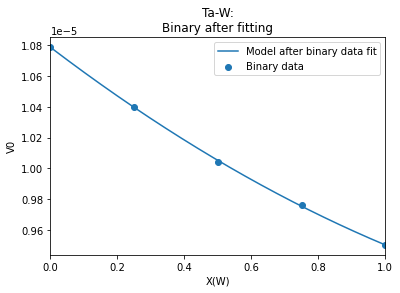

In [31]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "W"], "BCC_A2")

x_TA = np.linspace(0, 1, 1001)
x_W = 1-x_TA
x_TA_W = np.empty((x_TA.shape[-1], 2))
x_TA_W[:, 0] = x_TA
x_TA_W[:, 1] = x_W
func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
print("mix", data_5pt_V0_mix)
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Ta-W:\nBinary after fitting")
plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model after binary data fit")
plt.scatter(data_5pt_x_W, data_5pt_V0_fix, label='Binary data')
plt.legend()
plt.xlabel("X(W)")
plt.ylabel("V0")
plt.xlim(0, 1)

## Mixing

In [32]:
molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
datasets = [
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0_MIX",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]], [["TA", "W"]], [["TA", "W"]]], "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]},
        "values": [[[-6.58257874e-08, -1.00257453e-07, -6.37684692e-08]]],
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
dbf = Database("lu2005-volumes.tdb")

fit_model_x(molar_volume_fit_desc, datasets, dbf)

fitting_step <class '__main__.StepV0'>
sample_condition_dicts [{T: 298.15, P: 101315.0, YS: 0.1875, Y(BCC_A2,0,TA): 0.75, Y(BCC_A2,0,W): 0.25, Z: 0.5}, {T: 298.15, P: 101315.0, YS: 0.25, Y(BCC_A2,0,TA): 0.5, Y(BCC_A2,0,W): 0.5, Z: 0.0}, {T: 298.15, P: 101315.0, YS: 0.1875, Y(BCC_A2,0,TA): 0.25, Y(BCC_A2,0,W): 0.75, Z: -0.5}]
data_qtys 1 [{'components': ['TA', 'W'], 'phases': ['BCC_A2'], 'conditions': {'P': 101315, 'T': array([298.15])}, 'output': 'V0_MIX', 'solver': {'mode': 'manual', 'sublattice_site_ratios': [1], 'sublattice_configurations': ((('TA', 'W'),), (('TA', 'W'),), (('TA', 'W'),)), 'sublattice_occupancies': [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]}, 'values': [[[-6.58257874e-08, -1.00257453e-07, -6.37684692e-08]]], 'reference': 'VASP (LLNL)', 'bibtex': 'UNPUBLISHED', 'comment': 'Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING', 'tags': ['non-equilibrium-thermochemical', 'LLNL-proprietary']}]
REF [[-6.58257874e-08*(BCC_A20TA + BCC_A20W)]

mix [ 0.00000000e+00 -6.58257874e-08 -1.00257453e-07 -6.37684692e-08
  0.00000000e+00]
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

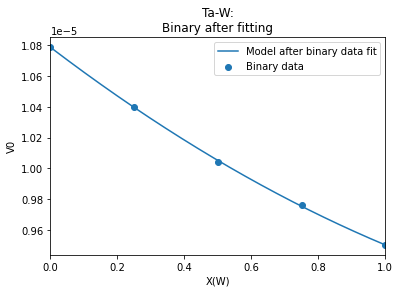

In [33]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "W"], "BCC_A2")

x_TA = np.linspace(0, 1, 1001)
x_W = 1-x_TA
x_TA_W = np.empty((x_TA.shape[-1], 2))
x_TA_W[:, 0] = x_TA
x_TA_W[:, 1] = x_W
func_V0_TA_W = lambdify([v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
print("mix", data_5pt_V0_mix)
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Ta-W:\nBinary after fitting")
plt.plot(x_W, func_V0_TA_W(x_TA_W), label="Model after binary data fit")
plt.scatter(data_5pt_x_W, data_5pt_V0_fix, label='Binary data')
plt.legend()
plt.xlabel("X(W)")
plt.ylabel("V0")
plt.xlim(0, 1)

# Ternary

start with binary fitting

In [85]:
molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
datasets = [
    {
        "components": ["TA", "W"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0_MIX",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["TA", "W"]], [["TA", "W"]], [["TA", "W"]]], "sublattice_occupancies": [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]},
        "values": [[[-6.58257874e-08, -1.00257453e-07, -6.37684692e-08]]],
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
dbf = Database("lu2005-volumes.tdb")

fit_model_x(molar_volume_fit_desc, datasets, dbf)

fitting_step <class '__main__.StepV0'>
sample_condition_dicts [{T: 298.15, P: 101315.0, YS: 0.1875, Y(BCC_A2,0,TA): 0.75, Y(BCC_A2,0,W): 0.25, Z: 0.5}, {T: 298.15, P: 101315.0, YS: 0.25, Y(BCC_A2,0,TA): 0.5, Y(BCC_A2,0,W): 0.5, Z: 0.0}, {T: 298.15, P: 101315.0, YS: 0.1875, Y(BCC_A2,0,TA): 0.25, Y(BCC_A2,0,W): 0.75, Z: -0.5}]
data_qtys 1 [{'components': ['TA', 'W'], 'phases': ['BCC_A2'], 'conditions': {'P': 101315, 'T': array([298.15])}, 'output': 'V0_MIX', 'solver': {'mode': 'manual', 'sublattice_site_ratios': [1], 'sublattice_configurations': ((('TA', 'W'),), (('TA', 'W'),), (('TA', 'W'),)), 'sublattice_occupancies': [[[0.75, 0.25]], [[0.5, 0.5]], [[0.25, 0.75]]]}, 'values': [[[-6.58257874e-08, -1.00257453e-07, -6.37684692e-08]]], 'reference': 'VASP (LLNL)', 'bibtex': 'UNPUBLISHED', 'comment': 'Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING', 'tags': ['non-equilibrium-thermochemical', 'LLNL-proprietary']}]
REF [[-6.58257874e-08*(BCC_A20TA + BCC_A20W)]

mix [ 0.00000000e+00 -6.58257874e-08 -1.00257453e-07 -6.37684692e-08
  0.00000000e+00]
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

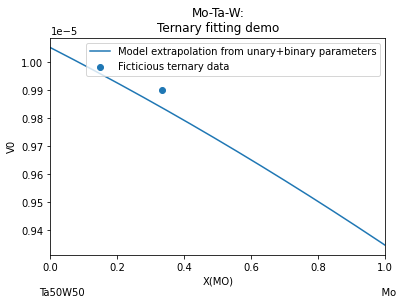

In [86]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "MO", "W"], "BCC_A2")

x_MO = np.linspace(0, 1, 1001)
x_TA = (1 - x_MO) / 2
x_W = (1 - x_MO) / 2
x_MO_TA_W = np.empty((x_MO.shape[-1], 3))
x_MO_TA_W[:, 0] = x_MO
x_MO_TA_W[:, 1] = x_TA
x_MO_TA_W[:, 2] = x_W
func_V0_MO_TA_W = lambdify([v.Y("BCC_A2", 0, "MO"), v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
print("mix", data_5pt_V0_mix)
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Mo-Ta-W:\nTernary fitting demo")
plt.plot(x_MO, func_V0_MO_TA_W(x_MO_TA_W), label="Model extrapolation from unary+binary parameters")
plt.scatter(0.333, 0.99e-5, label='Ficticious ternary data')
plt.legend(loc="upper right")
plt.xlabel(f"X(MO)\nTa50W50{'':>95}Mo")
plt.ylabel("V0")
plt.xlim(0, 1)

## Fit

In [87]:
molar_volume_fit_desc = ModelFittingDescription(StepV0, StepLogVA)
datasets = [
    {
        "components": ["MO", "TA", "W"],
        "phases": ["BCC_A2"],
        "conditions": {"P": 101315, "T": 298.15},
        "output": "V0",
        "solver": {"mode": "manual", "sublattice_site_ratios": [1], "sublattice_configurations": [[["MO", "TA", "W"]]], "sublattice_occupancies": [[[0.333333, 0.333333, 0.333333]]]},
        "values": [[[0.99e-5]]],  # ficitious value
        "reference": "VASP (LLNL)",
        "bibtex": "UNPUBLISHED",
        "comment": "Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING",
        "tags": ["non-equilibrium-thermochemical", "LLNL-proprietary"]
    }
]
mod = Model(dbf, ["MO", "TA", "W"], "BCC_A2")

print(f"Model components (for verification): {mod.components}")

Model components (for verification): [Species('MO', 'MO1'), Species('TA', 'TA1'), Species('W', 'W1')]


In [88]:
fit_model_x(molar_volume_fit_desc, datasets, dbf)

fitting_step <class '__main__.StepV0'>
sample_condition_dicts [{T: 298.15, P: 101315.0, YS: 0.03703692592603703, Y(BCC_A2,0,MO): 0.333333, Y(BCC_A2,0,TA): 0.333333, Y(BCC_A2,0,W): 0.333333, V_I: 0.3333333333333333, V_J: 0.3333333333333333, V_K: 0.3333333333333333}]
data_qtys 1 [{'components': ['MO', 'TA', 'W'], 'phases': ['BCC_A2'], 'conditions': {'P': 101315, 'T': array([298.15])}, 'output': 'V0', 'solver': {'mode': 'manual', 'sublattice_site_ratios': [1], 'sublattice_configurations': ((('MO', 'TA', 'W'),),), 'sublattice_occupancies': [[[0.333333, 0.333333, 0.333333]]]}, 'values': [[[9.9e-06]]], 'reference': 'VASP (LLNL)', 'bibtex': 'UNPUBLISHED', 'comment': 'Brandon Bocklund DFT calculations. VASP, PBEsol, PAW 400 eV cutoff, 0.2 KSPACING', 'tags': ['non-equilibrium-thermochemical', 'LLNL-proprietary']}]
data_qtys 2 [9.9e-06*(BCC_A20MO + BCC_A20TA + BCC_A20W)]
data_qtys 3 [-1.0*(BCC_A20MO + BCC_A20TA + BCC_A20W)*(9.34611e-06*BCC_A20MO + 1.07866e-05*BCC_A20TA + 9.50328e-06*BCC_A20W - 3

mix [ 0.00000000e+00 -6.58257874e-08 -1.00257453e-07 -6.37684692e-08
  0.00000000e+00]
[1.07870000e-05 1.04002492e-05 1.00448925e-05 9.76045653e-06
 9.50330000e-06]


(0.0, 1.0)

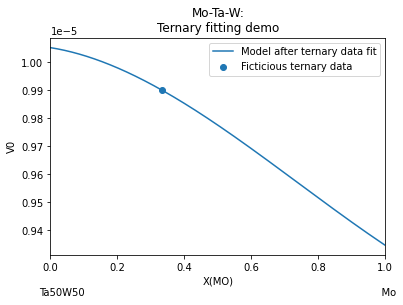

In [89]:
# important, do not reload the database because we just added a new parameter!
mod = Model(dbf, ["TA", "MO", "W"], "BCC_A2")

x_MO = np.linspace(0, 1, 1001)
x_TA = (1 - x_MO) / 2
x_W = (1 - x_MO) / 2
x_MO_TA_W = np.empty((x_MO.shape[-1], 3))
x_MO_TA_W[:, 0] = x_MO
x_MO_TA_W[:, 1] = x_TA
x_MO_TA_W[:, 2] = x_W
func_V0_MO_TA_W = lambdify([v.Y("BCC_A2", 0, "MO"), v.Y("BCC_A2", 0, "TA"), v.Y("BCC_A2", 0, "W")], [mod.V0])

v0_calphad = {  # these were extracted "by hand" from the print output above
    "CR": 7.0403e-06,
    "FE": 7.0079e-06,
    "MO": 9.3461e-06,
    "NB": 1.0752e-05,
    "TA": 1.0787e-05,
    "TI": 1.0592e-05,
    "V": 8.2481e-06,
    "W": 9.5033e-06,
    "ZR": 1.3812e-05,
}

# raw V0s from DFT
data_5pt_x_W = np.asarray([0, 0.25, 0.50, 0.75, 1.0])
data_5pt_V0 = np.asarray([1.0648e-05, 1.0287174212562773e-05, 9.957742546823015e-06, 9.699231530816361e-06, 9.468e-06])

# fix the reference state to match calphad
#                     V0             DFT V0_Ta * x_TA              +      DFT V0_W * x_W
# mixing reference state
data_5pt_V0_mix = data_5pt_V0 - (data_5pt_V0[0]*(1-data_5pt_x_W) + data_5pt_V0[-1]*(data_5pt_x_W))
print("mix", data_5pt_V0_mix)
# absolute values of Calphad unary + DFT_MIX binary
#                Calphad V0_Ta * x_TA               +       Calphad V0_W * x_W       +  DFT V0 MIX
data_5pt_V0_fix = v0_calphad["TA"]*(1-data_5pt_x_W) + v0_calphad["W"]*(data_5pt_x_W) + data_5pt_V0_mix
print(data_5pt_V0_fix)

plt.title("Mo-Ta-W:\nTernary fitting demo")
plt.plot(x_MO, func_V0_MO_TA_W(x_MO_TA_W), label="Model after ternary data fit")
plt.scatter(0.333, 0.99e-5, label='Ficticious ternary data')
plt.legend(loc="upper right")
plt.xlabel(f"X(MO)\nTa50W50{'':>95}Mo")
plt.ylabel("V0")
plt.xlim(0, 1)